# PREDICTING MARKET STATES USING HIDDEN MARKOV MODELS AND RELEVANT RISK SIGNALS

## Problem presentation
* Research project in partnership with Windham Capital Management, quantitative asset allocation firm located in Boston  
* Objective: predict market states for investment purposes
* Tools: daily Russell 3000 index (from 1/1/1998 to 8/31/2021), hidden Markov models, 7 proprietary risk signals (daily data)

## Preliminary steps

In [863]:
# Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [864]:
# Load data sets
russell = pd.read_csv('russell.csv')
signals = pd.read_csv('signals.csv', sep = ';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [865]:
russell

,Date,Open,High,Low,Close,Adj Close,Volume
0,1987-09-10,178.960007,178.960007,177.050003,178.830002,178.830002,0.0
1,1987-09-11,178.830002,181.470001,178.830002,181.339996,181.339996,0.0
2,1987-09-14,181.339996,182.250000,180.750000,181.789993,181.789993,0.0
3,1987-09-15,181.789993,181.789993,179.259995,179.270004,179.270004,0.0
4,1987-09-16,179.270004,180.630005,177.860001,177.889999,177.889999,0.0
...,...,...,...,...,...,...,...
8573,2021-09-16,2655.489990,2661.139893,2636.669922,2653.979980,2653.979980,0.0
8574,2021-09-17,2653.570068,2653.570068,2628.800049,2633.469971,2633.469971,0.0
8575,2021-09-20,2631.199951,2631.199951,2556.120117,2586.929932,2586.929932,0.0
8576,2021-09-21,2588.229980,2609.169922,2581.250000,2586.449951,2586.449951,0.0


In [866]:
signals

,Date,Signal 1,Signal 2,Signal 3,Signal 4,Signal 5,Signal 6,Signal 7
0,01/01/1998,0.996032,0.000000,0.000000,2.195791,0.000000,NaN,NaN
1,02/01/1998,0.988095,0.939153,0.956159,2.178339,0.934003,23.420000,NaN
2,05/01/1998,0.984127,0.937831,0.954629,2.161858,0.934003,24.360001,NaN
3,06/01/1998,0.980159,0.937831,0.953855,2.142903,0.931133,25.660000,NaN
4,07/01/1998,0.972222,0.935185,0.950137,2.124910,0.929699,25.070000,NaN
...,...,...,...,...,...,...,...,...
6088,25/08/2021,0.003968,0.566138,0.231783,-1.637820,0.533716,16.790001,108.839996
6089,26/08/2021,0.011905,0.546296,0.231176,-1.634421,0.502152,18.840000,116.599998
6090,27/08/2021,0.027778,0.559524,0.245270,-1.629395,0.512195,16.389999,109.620003
6091,30/08/2021,0.003968,0.533069,0.222149,-1.621646,0.479197,16.190001,107.900002


In [867]:
# Date formatting
russell.Date = pd.to_datetime(russell.Date)
signals.Date = pd.to_datetime(signals.Date, format = '%d/%m/%Y')

In [868]:
# Merge data sets
data = signals.merge(russell[['Date', 'Adj Close']], on = 'Date', how = 'outer').sort_values(by = 'Date').reset_index(drop = True)
data = data[data.Date <= min(russell.Date.values[-1], signals.Date.values[-1])]

In [869]:
# Fill in missing values
isnan = data.isnull()
for i in range(1,data.shape[0]):
  for j in range(1,data.shape[1]):
    if isnan.iloc[i,j]:
      data.iloc[i,j] = data.iloc[i-1,j]

In [870]:
# Remove spaces in column names
data.columns = [col.replace(' ', '') for col in data.columns]

In [871]:
# Compute returns
data['Return'] = data.AdjClose/data.AdjClose.shift(1)-1

In [872]:
# Split into training and test samples
data_train = data[data.Date <= '2019-12-31']

In [873]:
data_train

,Date,Signal1,Signal2,Signal3,Signal4,Signal5,Signal6,Signal7,AdjClose,Return
0,1987-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178.830002,NaN
1,1987-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.339996,0.014036
2,1987-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.789993,0.002482
3,1987-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.270004,-0.013862
4,1987-09-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,177.889999,-0.007698
...,...,...,...,...,...,...,...,...,...,...
8276,2019-12-24,0.619048,0.247354,0.403510,0.937200,0.213773,12.67,98.830002,1889.630005,0.000085
8277,2019-12-26,0.603175,0.207672,0.373400,0.909716,0.195122,12.65,97.459999,1898.239990,0.004556
8278,2019-12-27,0.607143,0.183862,0.359525,0.878855,0.175036,13.43,99.629997,1897.239990,-0.000527
8279,2019-12-30,0.603175,0.160053,0.343120,0.842899,0.136298,14.82,100.019997,1886.660034,-0.005576


## Data visualization

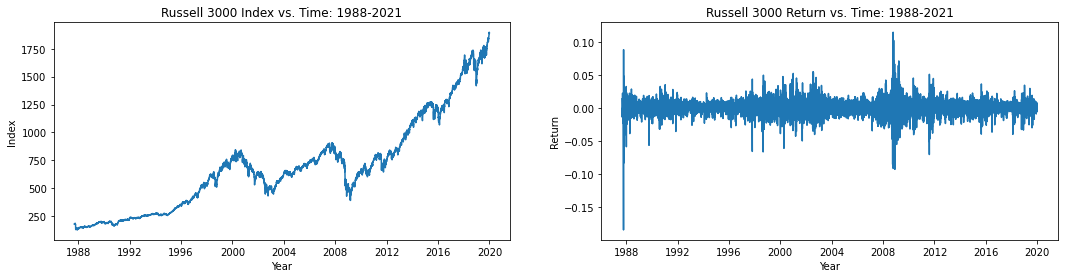

In [874]:
# Russell 3000
plt.figure(figsize = (18,4))

plt.subplot(1,2,1)
plt.plot(data_train.Date, data_train.AdjClose)
plt.title('Russell 3000 Index vs. Time: 1988-2021')
plt.xlabel('Year')
plt.ylabel('Index')

plt.subplot(1,2,2)
plt.plot(data_train.Date, data_train.Return)
plt.title('Russell 3000 Return vs. Time: 1988-2021')
plt.xlabel('Year')
plt.ylabel('Return')

plt.show()

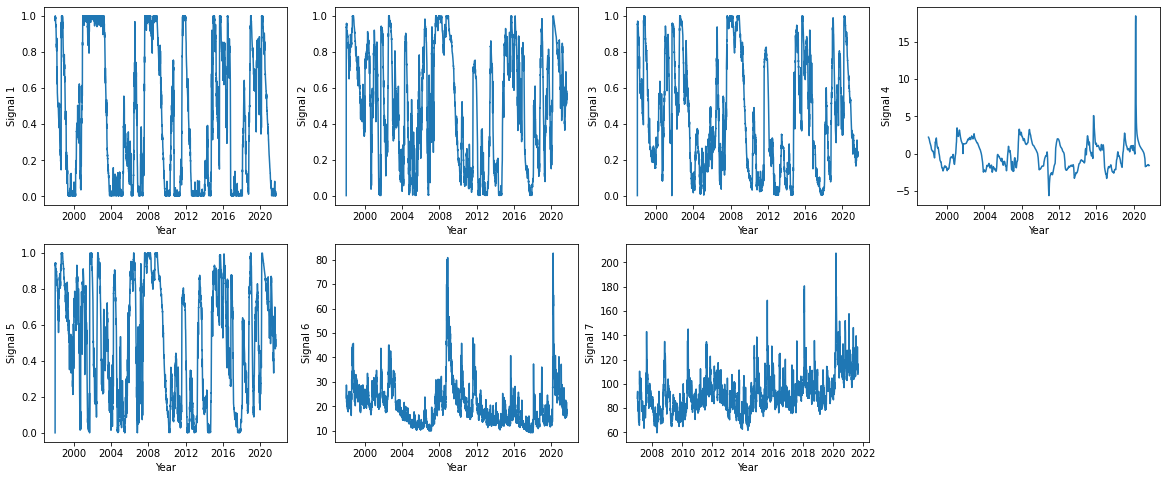

In [875]:
# Risk signals
plt.figure(figsize = (20,8))

for i in range(1,8):
  plt.subplot(2,4,i)
  plt.plot(data.Date, data['Signal'+str(i)])
  plt.xlabel('Year')
  plt.ylabel('Signal '+str(i))

## Markov regression

The goal of this part is to use the training data (specially the Russell 3000 daily returns) to determine the relevant market state (Bear or Bull) at each period.

The principle of a Markov regression is to fit the following model:

$$r_t = \mu_{S_t} + \epsilon_t, \ \epsilon_t \sim N(0,\sigma_{S_t}^2)$$

Where $S_t \in \{0,1\}$ and the transition matrix is given by:

$$
A = P(S_t=s_t | S_{t-1} = s_{t-1}) = \left(\begin{array}{cc}
p_{00} & p_{10}\\
1-p_{00} & 1-p_{10}
\end{array}\right)
$$

The model is fitted by finding the parameters $\mu_0, \ \mu_1, \ \sigma_0, \, \sigma_1$ and $A$ that maximize the following likelihood function (done by gradient descent):

$$P((r_t)_t \ | \ \mu_0, \ \mu_1, \ \sigma_0, \, \sigma_1, \ A)$$

In [876]:
# Perform Markov regression (in two steps to accelerate convergence)
mod = sm.tsa.MarkovRegression(endog = data_train.Return[1:100], k_regimes = 2, switching_variance = True)
res = mod.fit()
mod = sm.tsa.MarkovRegression(endog = data_train.Return[1:], k_regimes = 2, switching_variance = True)
res = mod.fit(start_params = res.params)

In [877]:
print(res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                 Return   No. Observations:                 8280
Model:               MarkovRegression   Log Likelihood               27102.948
Date:                Tue, 07 Jun 2022   AIC                         -54193.897
Time:                        15:55:56   BIC                         -54151.767
Sample:                             0   HQIC                        -54179.501
                               - 8280                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008   9.22e-05      8.755      0.000       0.001       0.001
sigma2      4.363e-05   1.44e-06     30.368      0.0

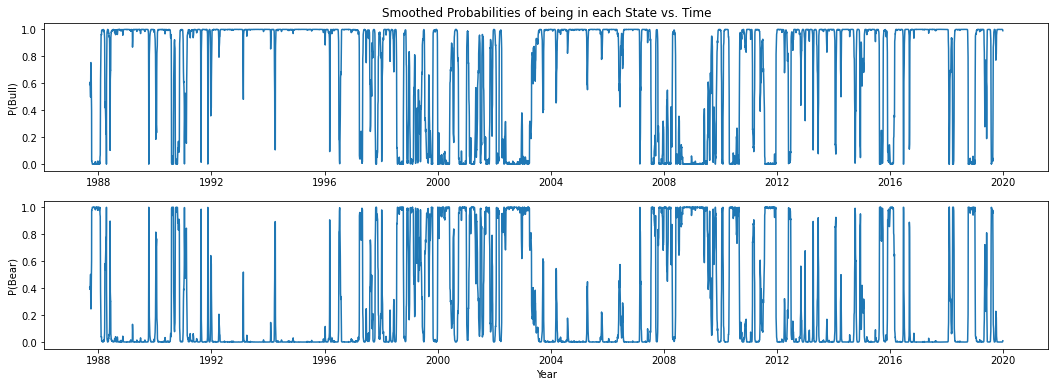

In [878]:
# Plot state probabilities
plt.figure(figsize = (18,6))

plt.subplot(2,1,1)
plt.plot(data_train.Date[1:], res.smoothed_marginal_probabilities[0])
plt.title('Smoothed Probabilities of being in each State vs. Time')
plt.ylabel('P(Bull)')

plt.subplot(2,1,2)
plt.plot(data_train.Date[1:], res.smoothed_marginal_probabilities[1])
plt.xlabel('Year')
plt.ylabel('P(Bear)')

plt.show()

In [879]:
# Add state probabilities to the training data set
data_train = pd.concat([data_train, res.smoothed_marginal_probabilities], axis = 1)
data_train.columns = list(data_train.columns[:-2])+['PBull', 'PBear']

In [880]:
# Estimate the state of the world (Bear = -1, Bull = 1, Uncertain = 0 if threshold > 0.5)
threshold = 0.9
data_train['State'] = (data_train.PBull >= threshold)*1 + (data_train.PBull < (1-threshold))*(-1)
data_train.State[0] = np.nan

For simplicity, we decided to take a threshold equal to 0.9. Therefore, in order to consider the market to be in the bull (resp. bear) state, the bull (resp. bear) probability needs to be greater than 0.9. Otherwise, the market will be considered as uncertain.

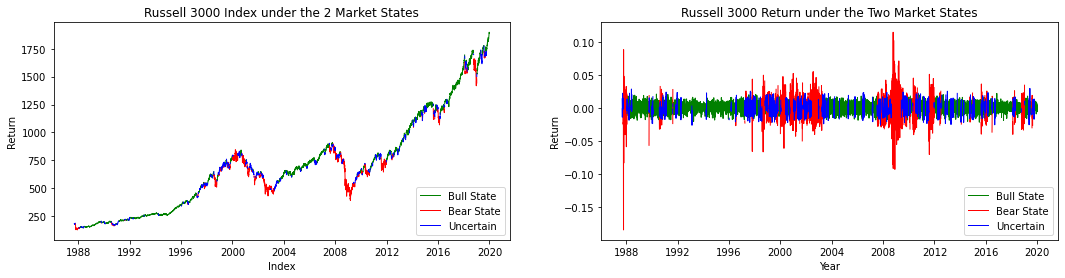

In [881]:
# Plots with colors
plt.figure(figsize = (18,4))

plt.subplot(1,2,1)
plt.plot(data_train.Date, np.ma.masked_where((data_train.State != 1), data_train.AdjClose), 'g', linewidth = 1, label = 'Bull State')
plt.plot(data_train.Date, np.ma.masked_where((data_train.State != -1), data_train.AdjClose), 'r', linewidth = 1, label = 'Bear State')
plt.plot(data_train.Date, np.ma.masked_where((data_train.State != 0), data_train.AdjClose), 'b', linewidth = 1, label = 'Uncertain')
plt.title('Russell 3000 Index under the 2 Market States')
plt.xlabel('Index')
plt.ylabel('Return')
plt.legend(loc = 'lower right')

plt.subplot(1,2,2)
plt.plot(data_train.Date, np.ma.masked_where((data_train.State != 1), data_train.Return), 'g', linewidth = 1, label = 'Bull State')
plt.plot(data_train.Date, np.ma.masked_where((data_train.State != -1), data_train.Return), 'r', linewidth = 1, label = 'Bear State')
plt.plot(data_train.Date, np.ma.masked_where((data_train.State != 0), data_train.Return), 'b', linewidth = 1, label = 'Uncertain')
plt.title('Russell 3000 Return under the Two Market States')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend(loc = 'lower right')

plt.show()

## Best predictive signal

The goal of this part is to use the risk signals and a bunch of machine learning algorithms to determine which best predicts the future states of the market.

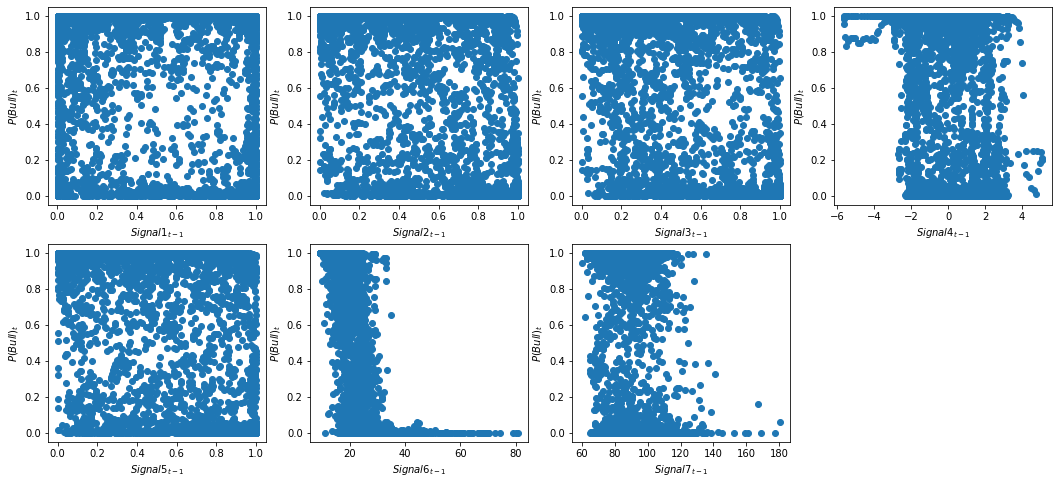

In [728]:
# Plot P(Bull) vs. lagged signals
plt.figure(figsize = (18,8))

for i in range(7):
  plt.subplot(2,4,i+1)
  plt.scatter(data_train['Signal'+str(i+1)].shift(1), data_train.PBull)
  plt.xlabel('$Signal'+str(i+1)+'_{t-1}$')
  plt.ylabel('$P(Bull)_t$')

### Training and validation sets

In [729]:
# Create lagged signals
def create_lags(df, n_lags):
  try:
    df = df.set_index('Date')
  except:
    pass
  sig = df[[col for col in df.columns if col.startswith('Signal')]]
  df = df.drop(sig.columns, axis = 1)
  for i in range(1, n_lags+1):
    if i == 1:
      df = pd.concat([pd.DataFrame(sig.shift(1).values, index = df.index, columns = [col+"_lag1" for col in sig.columns]), df], axis = 1)    
    else:
      sig_var = sig.shift(1)-sig.shift(i)
      df = pd.concat([pd.DataFrame(sig_var.values, index = df.index, columns = [col+"_var"+str(i-1) for col in sig.columns]), df], axis = 1)
  return df

In [730]:
# Select N random dates to divide the sample in into training and validation samples
def generate_dates(df, n_val_sets):
  np.random.seed(0)
  dates = []
  for i in range(n_val_sets):
    dates.append(df[df.index >= '2015-01-01'].sample(n = 1, replace = False).index.values[0])
  return dates

In [731]:
# Create train/validation couples
def create_couples(df, dates, n_val_days):
  train_val = []
  for date in dates:
    val = df[df.index <= date].iloc[-n_val_days:,:]
    train = df[df.index <= date].iloc[:(-n_val_days),:]
    train_val.append((train, val))
  return train_val

In [732]:
# Create valdiation function
def validation(train_val, classifier):
  # Create storage data frame
  res = pd.DataFrame(np.zeros((len(train_val), 7)), index = range(1, len(train_val)+1), columns = ['Signal'+str(i) for i in range(1,8)])

  for i in range(1,8):
    j = 1
    
    for train, val in train_val:
      # Define train/test variables
      df_train = train[[col for col in train.columns if (col.startswith('Signal'+str(i)) | (col == 'State'))]].dropna()
      X_train = df_train[[col for col in df_train.columns if col.startswith('Signal')]].values
      y_train = df_train.State.values
      df_val = val[[col for col in val.columns if (col.startswith('Signal'+str(i)) | (col == 'State'))]].dropna()
      X_val = df_val[[col for col in df_val.columns if col.startswith('Signal')]].values
      y_val = df_val.State.values
      
      # Scale X variable
      sc = StandardScaler()
      X_train = sc.fit_transform(X_train)
      
      # Train model
      clf = classifier
      clf.fit(X_train, y_train)
      
      # Evaluate out-of-sample using accuracy
      y_pred = clf.predict(sc.transform(X_val))
      res.loc[j,'Signal'+str(i)] = accuracy_score(y_val, y_pred)
      j += 1 

  # Return mean and std of accuracy for each predictive signal
  res = pd.concat([res.mean(axis = 0), res.std(axis = 0)], axis = 1)
  res.columns = ['Mean', 'Std']

  return res

In [733]:
# Parameters
n_lags = 5         # Number of lags to consider for each signal (1 month)
n_val_sets = 10    # Number of training/validation couples
n_val_days = 252   # Number of days in validation sets

data_train_lags = create_lags(data_train, n_lags)
dates = generate_dates(data_train_lags, n_val_sets)
train_val = create_couples(data_train_lags, dates, n_val_days)

The results below show the average accuracy as well as the standard deviation across the different training/validation sets. These scores must be compared to the proportion of the most represented class (63%).

### Logistic regression

In [734]:
# Results
res_logreg = validation(train_val, LogisticRegression())
res_logreg

,Mean,Std
Signal1,0.650000,0.199545
Signal2,0.687302,0.153562
Signal3,0.713095,0.186213
Signal4,0.702778,0.171381
Signal5,0.702381,0.162887
Signal6,0.798810,0.127864
Signal7,0.743254,0.086517


### K nearest neighbors

In [735]:
# n_neighbors = 5
res_knn5 = validation(train_val, KNeighborsClassifier(n_neighbors = 5))
res_knn5

,Mean,Std
Signal1,0.580159,0.154108
Signal2,0.586905,0.136832
Signal3,0.597619,0.186740
Signal4,0.546032,0.134975
Signal5,0.525000,0.135310
Signal6,0.809524,0.100512
Signal7,0.586508,0.060118


In [736]:
# n_neighbors = 10
res_knn10 = validation(train_val, KNeighborsClassifier(n_neighbors = 10))
res_knn10

,Mean,Std
Signal1,0.660317,0.167767
Signal2,0.651984,0.147260
Signal3,0.643254,0.187481
Signal4,0.542460,0.149231
Signal5,0.603571,0.141100
Signal6,0.810317,0.103120
Signal7,0.670635,0.074239


In [737]:
# n_neighbors = 50
res_knn50 = validation(train_val, KNeighborsClassifier(n_neighbors = 50))
res_knn50

,Mean,Std
Signal1,0.713095,0.164448
Signal2,0.724206,0.146763
Signal3,0.695635,0.194521
Signal4,0.632143,0.196899
Signal5,0.707143,0.167000
Signal6,0.811905,0.103364
Signal7,0.746429,0.092733


In [746]:
# n_neighbors = 100
res_knn100 = validation(train_val, KNeighborsClassifier(n_neighbors = 100))
res_knn100

,Mean,Std
Signal1,0.718651,0.161997
Signal2,0.729365,0.143307
Signal3,0.719841,0.199408
Signal4,0.650000,0.176406
Signal5,0.733730,0.154705
Signal6,0.806349,0.109697
Signal7,0.760317,0.109895


### SVM

In [738]:
# Results
res_svm = validation(train_val, SVC())
res_svm

,Mean,Std
Signal1,0.717857,0.166283
Signal2,0.738889,0.145199
Signal3,0.732540,0.191769
Signal4,0.737302,0.158629
Signal5,0.745635,0.152518
Signal6,0.810714,0.103108
Signal7,0.759127,0.097131


### Naive Bayes

In [739]:
# Results
res_nb = validation(train_val, GaussianNB())
res_nb

,Mean,Std
Signal1,0.729365,0.157277
Signal2,0.691667,0.158731
Signal3,0.754365,0.136422
Signal4,0.732937,0.157502
Signal5,0.757540,0.122673
Signal6,0.782540,0.089924
Signal7,0.714683,0.078955


### Random forest

In [740]:
# Results
res_rf = validation(train_val, RandomForestClassifier())
res_rf

,Mean,Std
Signal1,0.664286,0.159326
Signal2,0.688095,0.120133
Signal3,0.663095,0.181303
Signal4,0.628571,0.165679
Signal5,0.665476,0.116072
Signal6,0.809524,0.104103
Signal7,0.663889,0.069038


### XGBoost

In [741]:
# Results
res_xgb = validation(train_val, XGBClassifier())
res_xgb

,Mean,Std
Signal1,0.731349,0.155073
Signal2,0.722619,0.126216
Signal3,0.717063,0.189371
Signal4,0.680556,0.187245
Signal5,0.761111,0.130475
Signal6,0.815079,0.102378
Signal7,0.725000,0.066666


### Investment strategy

Signal 6 combined with XGB appears to be the best predictive signal. 
Let's use it for investment purposes on the test set (from 1/1/2020 to 8/31/2021). The rules are:
* Take a long position if the signal predicts a bull market.  
* Take a short position if the signal predicts a bear market.

In [747]:
# Isolate test set
data_lags = create_lags(data, n_lags)
data_test = data_lags[data_lags.index >= '2020-01-01']
X_test = data_test[[col for col in data_lags.columns if col.startswith('Signal6')]].values

In [748]:
# Fit KNN on whole training set using signal 6
df_train = data_train_lags[[col for col in data_train_lags.columns if (col.startswith('Signal6') | (col == 'State'))]].dropna()
X_train = df_train[[col for col in df_train.columns if col.startswith('Signal6')]].values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
y_train = df_train.State.values
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [749]:
# Implement investment strategy
state_pred = clf.predict(sc.transform(X_test))
strat_ret = []

for i in range(data_test.shape[0]):
  if state_pred[i] == -1:
    strat_ret.append(-data_test.Return[i])
  elif state_pred[i] == 0:
    strat_ret.append(0)
  else:
    strat_ret.append(data_test.Return[i])

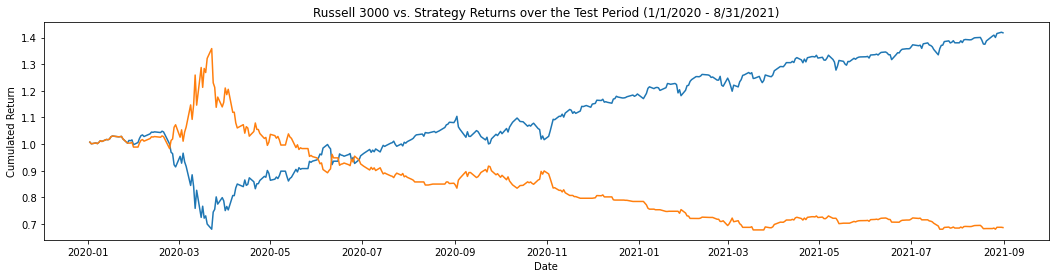

In [750]:
# Compare Russell 3000 cumulated returns with investment strategy
strat_cumret = np.cumprod([r+1 for r in strat_ret])
r3000_cumret = (1 + data_test.Return).cumprod()

plt.figure(figsize = (18,4))
plt.plot(data_test.index, r3000_cumret)
plt.plot(data_test.index, strat_cumret)
plt.title('Russell 3000 vs. Strategy Returns over the Test Period (1/1/2020 - 8/31/2021)')
plt.xlabel('Date')
plt.ylabel('Cumulated Return')
plt.show()

We can observe that our strategy anticipates very well the Covid 19 stock market crash. However, it performs very poorly at identifying the huge rebound that followed. It can be explained by the fact that Signal 6, although in decline, is still too high to show clear signs of market growth.

## Combined signals

In [814]:
# Choose classifiers
classifiers = [LogisticRegression(), 
               KNeighborsClassifier(n_neighbors = 5),
               KNeighborsClassifier(n_neighbors = 10),
               KNeighborsClassifier(n_neighbors = 50),
               KNeighborsClassifier(n_neighbors = 100),
               SVC(),
               GaussianNB(),
               RandomForestClassifier(),
               XGBClassifier()]

In [824]:
# Create storage data frame
res = pd.DataFrame(np.zeros((len(train_val), len(classifiers))), index = range(1, len(train_val)+1), 
                   columns = [str(classifier) for classifier in classifiers])
print('0/' + str(len(train_val)) + ' done')
k = 1

for train, val in train_val: 
  # Define train/test variables
  df_train = train.dropna()
  X_train = df_train[[col for col in df_train.columns if col.startswith('Signal')]].values
  y_train = df_train.State.values
  df_val = val.dropna()
  X_val = df_val[[col for col in df_val.columns if col.startswith('Signal')]].values
  y_val = df_val.State.values
  
  # Scale X variable
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_val = sc.transform(X_val)

  for classifier in classifiers:    
    # Train model
    clf = classifier
    clf.fit(X_train, y_train)
    
    # Evaluate out-of-sample
    y_pred = clf.predict(X_val)
    res.loc[k, str(classifier)] = accuracy_score(y_val, y_pred)

  print(str(k) + '/' + str(len(train_val)) + ' done')
  k += 1

# Return mean and std of accuracy for each predictive signal
res = pd.concat([res.mean(axis = 0), res.std(axis = 0)], axis = 1)
res.columns = ['Mean', 'Std']

0/10 done
1/10 done
2/10 done
3/10 done
4/10 done
5/10 done
6/10 done
7/10 done
8/10 done
9/10 done
10/10 done


In [825]:
# Results
res

,Mean,Std
LogisticRegression(),0.822222,0.108720
KNeighborsClassifier(),0.736111,0.129943
KNeighborsClassifier(n_neighbors=10),0.774603,0.127572
KNeighborsClassifier(n_neighbors=50),0.790476,0.134671
KNeighborsClassifier(n_neighbors=100),0.790079,0.138434
SVC(),0.807143,0.103229
GaussianNB(),0.728571,0.121350
RandomForestClassifier(),0.824603,0.102661
XGBClassifier(objective='multi:softprob'),0.826190,0.108010


It appears that logistic regression, random forest and XGB perform the best, even though all algorithms yield decent results.

In [855]:
# Fit XGB on whole training set
df_train = data_train_lags[[col for col in data_train_lags.columns if (col.startswith('Signal') | (col == 'State'))]].dropna()
X_train = df_train[[col for col in df_train.columns if col.startswith('Signal')]].values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
y_train = df_train.State.values
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [857]:
# Implement investment strategy
X_test = data_test[[col for col in data_test.columns if col.startswith('Signal')]].values
state_pred = clf.predict(sc.transform(X_test))
strat_ret = []

for i in range(data_test.shape[0]):
  if state_pred[i] == -1:
    strat_ret.append(-data_test.Return[i])
  elif state_pred[i] == 0:
    strat_ret.append(0)
  else:
    strat_ret.append(data_test.Return[i])

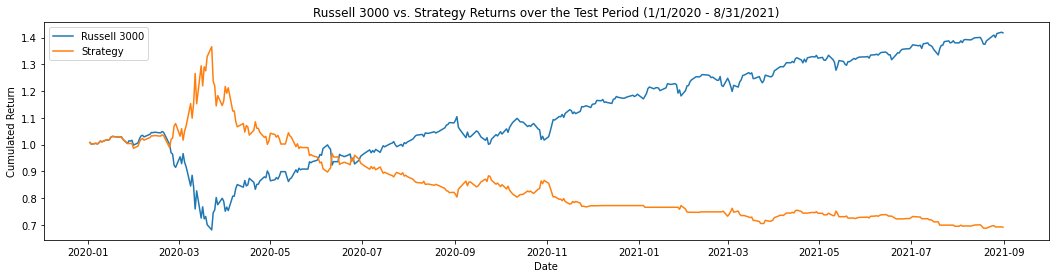

In [859]:
# Compare Russell 3000 cumulated returns with investment strategy
strat_cumret = np.cumprod([r+1 for r in strat_ret])
r3000_cumret = (1 + data_test.Return).cumprod()

plt.figure(figsize = (18,4))
plt.plot(data_test.index, r3000_cumret, label = 'Russell 3000')
plt.plot(data_test.index, strat_cumret, label = 'Strategy')
plt.title('Russell 3000 vs. Strategy Returns over the Test Period (1/1/2020 - 8/31/2021)')
plt.xlabel('Date')
plt.ylabel('Cumulated Return')
plt.legend()
plt.show()

Unfortunately, we could not improve the results. It appears that the different signals cannot manage to anticipate the market rebound that followed the Covid 19 crash.

An idea to improve the investment performance would be to look for other risk signals or find relevant transformation fucntions that we could apply to those we have available.

Finally, this result shows in a way the limits of machine learning for this kind of task. An algorithm can only predict patterns it has already encountered, but the post-Covid market rebound was an unprecedented event.